<a href="https://colab.research.google.com/github/LidaDavydova/MelanomaVenusClassification/blob/main/testModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import PIL
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import glob
# import pandas as pd
# from sklearn.utils import Bunch
# import pickle

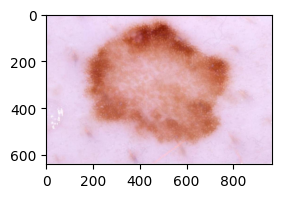

In [15]:
# upload img
img_path = '/home/hedg/Downloads/MEL_hairless/ISIC_0000162_hairless.jpg' # измени на путь к своему изображению (вроде работает для png и jpg формата)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(2,2,2)
plt.imshow(image)

In [27]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from tensorflow.keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        try:
            out_shape = l.output_shape
        except:
            continue
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [17]:
# upload model
model = tf.keras.models.load_model('/home/hedg/Downloads/model-72.keras') # измени на свой путь к модели .keras/.h5

In [28]:
get_model_memory_usage(16,model)

np.float64(0.098)

In [5]:
image = keras.utils.load_img(img_path, target_size=(224,224))
input_arr = keras.utils.img_to_array(image)
input_arr = np.array([input_arr])

In [6]:
pred = model.predict(input_arr)
pred2 = pred.tolist()[0]
diff = abs(pred2[0]-pred2[1])
pred, diff

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


(array([[0.9950244 , 0.00497562]], dtype=float32), 0.990048760548234)

In [10]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [12]:
tf.config.experimental.get_memory_usage('CPU:0')['current']

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.


241729536

In [13]:
range_len = 5.0
min_el = 8.369982242584229e-05

In [15]:
precis = (diff-min_el)/range_len

In [19]:
classes = {0: 'melanoma', 1: 'nevus'}
cls = tf.argmax(pred, axis=1)
print(f"На {round(precis*100, 2)}% модель уверенна, что на изображении {classes[int(cls)]}")

На 13.62% модель уверенна, что на изображении melanoma


In [20]:
def load_my_fancy_dataset(df):
    data = []
    target = []
    for i, row in df.iterrows():
        lst = row.tolist()
        features = lst[:-1]
        label = lst[-1]
        data.append([float(num) for num in features])
        target.append(int(label))
    
    data = np.array(data)
    target = np.array(target)
    return Bunch(data=data, target=target, feature_names=df.columns[:-1])

In [21]:
localization_dict_val = {
    'lower extremity': 0, 
    'torso': 1, 
    'upper extremity': 2, 
    'head/neck': 3,
    'unknown': 4, 
    'palms/soles': 5, 
    'oral/genital': 6, 
    'scalp': 7, 
    'ear': 8, 
    'face': 9,
    'back': 10, 
    'trunk': 11, 
    'chest': 12, 
    'abdomen': 13, 
    'genital': 6, 
    'neck': 14, 
    'hand': 15,
    'foot': 16, 
    'acral': 17
}

In [30]:
sex = 'female'
age = 5
localization = 'hand'

In [31]:
target = 0 if cls == 1 else 1 # because of error while model fitting
features = pd.DataFrame([{
    'advantage': diff,
    'sex': sex,
    'age': age,
    'localization': localization,
    'target': target
}])
features.localization = features.localization.map(localization_dict_val)
features.sex = features.sex.map({'male': 0, 'female': 1})
features = load_my_fancy_dataset(features)

In [32]:
features.target

array([1])

In [33]:
# load
with open('models/model_sklearn_1_0.pkl', 'rb') as f:
    gb = pickle.load(f)

In [34]:
y_pred_gb = gb.predict(features.data)
y_pred_gb

array([0])

In [39]:
classes_for_2_model = {1: 'melanoma', 0: 'nevus'}

In [48]:
if features.target == y_pred_gb:
    if features.target == 1:
        print("melanoma")
    else:
        print("nevus")
else:
    print(f"1 модель рапознала {classes[int(cls)]}, 2 модель (на основе данных из первой) определила {classes_for_2_model[int(y_pred_gb[0])]}")

print(f"1 модель уверенна на {round(precis*100, 2)}%, что на изображении {classes[int(cls)]}")

1 модель рапознала melanoma, 2 модель (на основе данных из первой) определила nevus
1 модель уверенна на 13.62%, что на изображении melanoma
